# Predicting Fraudulent Reviews from the Yelp Dataset using BERT

        Faiz Ganz, Tashrif Chowdhury, Akhilesh Chandrashekar, Zhenghao Li, Terrell Nowlin
                                New York University

In [ ]:
import matplotlib.pyplot as plt
import string
import numpy as np

import warnings

Ignoring warning for presentation purposes.

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams["figure.figsize"] = (10,6)

## Data and Preprocessing

#### Loading Data

In [ ]:
import pandas as pd

data = pd.read_csv('reviewContent',
                   sep="\t",
                   names=['user_id', 'prod_id', 'date', 'review'])

meta = pd.read_csv('metadata',
                   sep='\t',
                   names = ['user_id', 'prod_id', 'rating', 'label', 'date'])

df = pd.merge(data, meta, on = ['user_id', 'date', 'prod_id'])
df

,user_id,prod_id,date,review,rating,label
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,3.0,-1
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,3.0,-1
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,4.0,-1
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,4.0,-1
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,4.0,-1
...,...,...,...,...,...,...
358952,161146,349,2014-02-06,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1
358953,116424,349,2014-01-31,Can't say enough good things about this place....,5.0,1
358954,161147,349,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",5.0,1
358955,97930,349,2014-01-25,"Great foods and great drinks, they have even p...",5.0,1


#### Preprocessing

Relabeling samples. BERT needs non-negative labels. (Fradulent = 1, True = 0)

In [ ]:
df.loc[df.label == 1, 'label'] = 0
df.loc[df.label == -1, 'label'] = 1
df

,user_id,prod_id,date,review,rating,label
0,923,0,2014-12-08,The food at snack is a selection of popular Gr...,3.0,1
1,924,0,2013-05-16,This little place in Soho is wonderful. I had ...,3.0,1
2,925,0,2013-07-01,ordered lunch for 15 from Snack last Friday. ...,4.0,1
3,926,0,2011-07-28,This is a beautiful quaint little restaurant o...,4.0,1
4,927,0,2010-11-01,Snack is great place for a casual sit down lu...,4.0,1
...,...,...,...,...,...,...
358952,161146,349,2014-02-06,"I'm very spoiled with Pizza. Really, I have tr...",5.0,0
358953,116424,349,2014-01-31,Can't say enough good things about this place....,5.0,0
358954,161147,349,2014-01-30,"Had a great dinner here- fantastic pizza, the ...",5.0,0
358955,97930,349,2014-01-25,"Great foods and great drinks, they have even p...",5.0,0


Because BERT takes in only text data have decided to include the other features as part of the review text and placed them at the beginning of each review. Next, we take only the "review" and "label" features of the data.

In [ ]:
df.loc[df.label == 0, 'review'] = (df.loc[df.label == 0, 'user_id'].astype(str) + ' '
                                + df.loc[df.label == 0, 'prod_id'].astype(str) + ' '
                                + df.loc[df.label == 0, 'date'].astype(str) + ' '
                                + df.loc[df.label == 0, 'rating'].astype(str) + ' '
                                + df.loc[df.label == 0, 'review'])

df.loc[df.label == 1, 'review'] = (df.loc[df.label == 1, 'user_id'].astype(str) + ' '
                                + df.loc[df.label == 1, 'prod_id'].astype(str) + ' '
                                + df.loc[df.label == 1, 'date'].astype(str) + ' '
                                + df.loc[df.label == 1, 'rating'].astype(str) + ' '
                                + df.loc[df.label == 1, 'review'])
df = df[['review', 'label']]
df

,review,label
0,923 0 2014-12-08 3.0 The food at snack is a se...,1
1,924 0 2013-05-16 3.0 This little place in Soho...,1
2,925 0 2013-07-01 4.0 ordered lunch for 15 from...,1
3,926 0 2011-07-28 4.0 This is a beautiful quain...,1
4,927 0 2010-11-01 4.0 Snack is great place for ...,1
...,...,...
358952,161146 349 2014-02-06 5.0 I'm very spoiled wit...,0
358953,116424 349 2014-01-31 5.0 Can't say enough goo...,0
358954,161147 349 2014-01-30 5.0 Had a great dinner h...,0
358955,97930 349 2014-01-25 5.0 Great foods and great...,0


#### Partitioning into Training and Testing

From the training partition of the dataset we will get our training and validation sets and from the testing portion we will get different testing sets for final evaluation.

In [ ]:
training_portion = 0.8
n_samples = len(df)

isplit = int(training_portion * n_samples)

df_train = df[:isplit]
df_test = df[isplit:]

#### Label Distributions

In [ ]:
print('Data Label Distribution:')
print(df['label'].value_counts())

print('\nTraining Label Distribution:')
print(df_train['label'].value_counts())

print('\nTesting Label Distribution:')
print(df_test['label'].value_counts())

Data Label Distribution:
0    322097
1     36860
Name: label, dtype: int64

Training Label Distribution:
0    257470
1     29695
Name: label, dtype: int64

Testing Label Distribution:
0    64627
1     7165
Name: label, dtype: int64


#### Correcting for Training Imbalance via Downsampling

We can see out of all samples about 10 percent are fraudulent and about 90 percent are true. This constitutes a problem for training because the classes are not balanced. We tested to see if this was indeeed problematic and it was as expected. Due to the class inbalanced the model was completely bias and thought that almost all reviews were true since that by simply predicting all reviews to be true it would achieve ~90% accuracy. In order for our model to properly learn, we decided to undersample the training set's true reviews to the size of the fraudulent one, obtaining a 50/50 split. We chose to undersample instead of oversampling because we already had a significant number of datapoints. 

In [ ]:
df_train_fraud = df_train.loc[df_train.label == 1]
df_train_true = df_train.loc[df_train.label == 0].sample(len(df_train_fraud), random_state=42)

train = pd.concat([df_train_true, df_train_fraud])

print('Training Distribution:')
print(train['label'].value_counts())

Training Distribution:
0    29695
1    29695
Name: label, dtype: int64


#### Selecting Training, Validation, and Testing Datasets

Now we select the portions of each set that we will use for training. Training on less that 100 datapoints does not yield great results and it overfitts more quickly. In order to obtain strong results we decided to train on ~52k parameters, which is 90 percent of our training samples and are cross-validating with the remaining 10 percent. For testing, we are using 5000 samples.

In [ ]:
from sklearn.model_selection import train_test_split

train_samples = len(train)
dev_size=0.1

train = train.sample(train_samples, random_state=42)
train, dev = train_test_split(train, test_size=dev_size, stratify=train['label'])

print('Training Distribution:')
print(train['label'].value_counts())
print('\nValidation Distribution:')
print(dev['label'].value_counts())

test = df_test
test_samples = 5000

test1 = test.sample(test_samples)
print('\nTest 1 Distribution:')
print(test1['label'].value_counts())
test2 = test.sample(test_samples)
print('\nTest 2 Distribution:')
print(test2['label'].value_counts())
test3 = test.sample(test_samples)
print('\nTest 3 Distribution:')
print(test3['label'].value_counts())

Training Distribution:
1    26726
0    26725
Name: label, dtype: int64

Validation Distribution:
0    2970
1    2969
Name: label, dtype: int64

Test 1 Distribution:
0    4512
1     488
Name: label, dtype: int64

Test 2 Distribution:
0    4475
1     525
Name: label, dtype: int64

Test 3 Distribution:
0    4499
1     501
Name: label, dtype: int64


## Preparing Data for BERT

In [ ]:
import torch
import transformers

#### Creating Tokenizer

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#### Distribution of Review Word Counts

Max review length: 5337


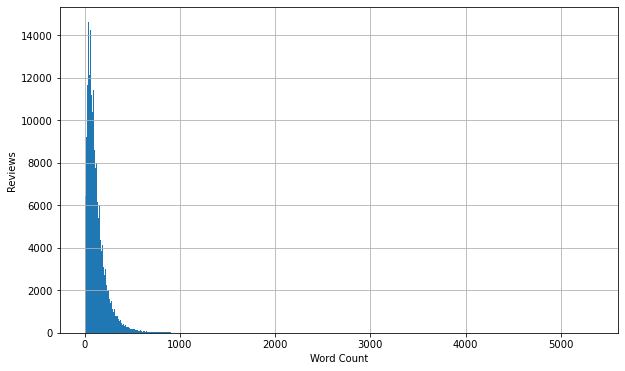

In [ ]:
word_counts = df['review'].str.split().str.len()

hist = word_counts.hist(bins=1000)
hist.set_xlabel('Word Count')
hist.set_ylabel('Reviews')

max_length = np.max(word_counts)
print('Max review length: {}'.format(max_length))

#### Encoding Reviews and Tokenizer Parameters

Using the endcode_plus method from the BERT Tokenizer to get our input_ids and attention_mask for training. For the encoding we used 512 as the maximum number of tokens. This is the maximum number of tokens the model allows to use. We chose to use the maximum because a good portion of the samples are even longer than 512 words. In the event that the review is longer than 512 word, the review is going to be truncated. If it is shorter, padding is going to be added.

We reference the help of the following https://medium.com/analytics-vidhya/a-gentle-introduction-to-implementing-bert-using-hugging-face-35eb480cff3 for this part.

In [ ]:
def encode(data, tokenizer):
    input_ids = []
    attention_mask = []
    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=512,
                                            add_special_tokens = True,
                                            padding = 'max_length',
                                            truncation=True,
                                            return_attention_mask=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_mask.append(tokenized_text['attention_mask'])
    
    return torch.tensor(input_ids, dtype=torch.long), torch.tensor(attention_mask, dtype=torch.long)

#### Creating PyTorch DataLoader Batched Dataset

It is necessary to feed the data to the model in batches. In our case, we chose to create batches made up from 2 samples as we do not meet the memory requirements for larger batches. Batches are sampled at random each epoch thanks to the Random Sampler.

In [ ]:
def get_batches(df, tokenizer, batch_size=2):
    x = list(df['review'].values)
    
    y_indices = df['label']
    
    y = torch.tensor(list(y_indices), dtype=torch.long)
    input_ids, attention_mask = encode(x, tokenizer)
    tensor_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, y)
    
    tensor_randomsampler = torch.utils.data.RandomSampler(tensor_dataset)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset,
                                                    sampler=tensor_randomsampler,
                                                    batch_size=batch_size)

    return tensor_dataloader

Creating batched datasets...

In [ ]:
batch_train = get_batches(train, tokenizer, batch_size=2)
batch_dev = get_batches(dev, tokenizer, batch_size=2)

## Evaluation and  Training Functions

#### Importing Sklearn Metrics

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

#### Evaluation

In [ ]:
def evaluate(batch, model, device):
    input_ids, predictions, true_labels, attentions, losses = [], [], [], [], []
    model.eval()
    for i, batch_cpu in enumerate(batch):
        batch_gpu = (t.to(device) for t in batch_cpu)
        input_ids_gpu, attention_mask, labels = batch_gpu
        with torch.no_grad():
            loss, logits, hidden_states_output, attention_mask_output = model(input_ids=input_ids_gpu,
                                                                              attention_mask=attention_mask,
                                                                              labels=labels,
                                                                              return_dict = False)
            logits =  logits.cpu()
            prediction = torch.argmax(logits, dim=1).tolist()
            true_label = labels.cpu().tolist()
            input_ids_cpu = input_ids_gpu.cpu().tolist()
            attention_last_layer = attention_mask_output[-1].cpu() # selection the last attention layer
            attention_softmax = attention_last_layer[:,-1, 0].tolist()  # selection the last head attention of CLS token
            input_ids += input_ids_cpu
            predictions += prediction
            true_labels += true_label
            attentions += attention_softmax
            losses.append(loss.item())
            
    total_loss = np.mean(losses)
    
    return input_ids, predictions, true_labels, attentions, total_loss


#### Training

In [ ]:
def train_model(batch, batch_dev, model, optimizer, scheduler, epochs, device):
    
    predictions, true_labels, losses = [], [], []
    train_loss, train_acc, train_auc = [], [], [], 
    dev_loss, dev_acc, dev_auc = [], [], []
    
    for e in range(epochs):
        model.train()  # Set the mode to training
            
        print('Epoch {}/{}'.format(e + 1, epochs))
        for i, batch_tuple in enumerate(batch):
            
            batch_tuple = (t.to(device) for t in batch_tuple)
            input_ids, attention_mask, labels = batch_tuple
            
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels,
                            return_dict=False)
            loss, logits, hidden_states_output, attention_mask_output = outputs
            
            if i % 100 == 0:
                print("loss - {0}, iteration - {1}/{2}/{3}".format(loss, e + 1, i, len(batch)))
            
            logits =  logits.cpu()
            prediction = torch.argmax(logits, dim=1).tolist()
            predictions += prediction
            true_label = labels.cpu().tolist()
            true_labels += true_label
            losses.append(loss.item())
            
            model.zero_grad()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['max_grad_norm'])
            optimizer.step()
            scheduler.step()
            
        # Training Statistics
        # Train Loss
        train_loss.append(np.mean(losses))
        print('\tTraining Loss = {}'.format(np.mean(losses)))
        
        # Train Accuracy
        acc_train = accuracy_score(true_labels, predictions)
        train_acc.append(acc_train)
        print('\tTraining Accuracy = {}'.format(acc_train))
        
        # Train AUC
        fpr, tpr, _ = roc_curve(true_labels, predictions, pos_label = 1)
        auc_train = auc(fpr, tpr)
        train_auc.append(auc_train)
        
        # Evaluation on Validation Set
        model.eval()
        input_ids, predictions, true_labels, attentions, epoch_dev_loss = evaluate(batch_dev, model, device)
        
        # Dev Loss
        dev_loss.append(np.mean(epoch_dev_loss))
        print('\tDev Loss = {}'.format(np.mean(epoch_dev_loss)))
        
        # Dev Accuracy
        acc_dev = accuracy_score(true_labels, predictions)
        dev_acc.append(acc_dev)
        print('\tDev Accuracy = {}'.format(acc_dev))
        
        # Dev AUC
        fpr, tpr, _ = roc_curve(true_labels, predictions, pos_label = 1)
        auc_dev = auc(fpr, tpr)
        dev_auc.append(auc_dev)
        
        
        
    return train_loss, dev_loss, train_acc, dev_acc, train_auc, dev_auc


## Hugging Face's BERT for Sequence Classification

#### Epochs, Optimizer, Scheduler, and Model Parameters

Just as for the tokenizer, the model is pre-trainer and imported from the **transformers** class. The parameters are listed below. From testing observations, we chose a learning rate of 2e-5 and a number of warm-up steps proportional to the number of batches. The number of warm-up steps choses how quickly the learning rate converges towards the specified value. Hence, the optimizer starts slowly and gains "confidence" over time. We have observed that for 10000 samples, 5000 warm up steps are sufficient from preventing overfitting too soon.

In [ ]:
epochs = 8

parameters = {
    'learning_rate': 2e-5,
    'num_warmup_steps': 18000,
    'num_training_steps': len(batch_train) * epochs,
    'max_grad_norm': 1,
    'hidden_states': 200,
    'n_labels': 2,
    'eps': 1e-8
}

#### Using CUDA and GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### Model

In [ ]:
from transformers import BertForSequenceClassification
from torch import nn

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=parameters['hidden_states'],
                                                      output_hidden_states=True,
                                                      output_attentions=True)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(parameters['hidden_states'], parameters['n_labels']))
model.classifier.add_module('prediction', nn.Dropout(p=0.5))
model.classifier.add_module('prediction', nn.Linear(parameters['hidden_states'], parameters['n_labels']))

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Optimizer

In [ ]:
optimizer = transformers.AdamW(model.parameters(), 
                               lr=parameters['learning_rate'],
                               eps = parameters['eps'],
                               correct_bias=False)

#### Scheduler

In [ ]:
scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                                         num_warmup_steps=parameters['num_warmup_steps'],
                                                         num_training_steps=parameters['num_training_steps'])

We have modified the model to have two-hundred neurons in the output layer and pass the output of each neuron through and hyperbolic tangent activation, and added on top of this a two-hundred dense layer with a dropout of 0.5, another 200 dense layer and a final output layer of two neurons corresponding to the two classes in our dataset. For this we took inspiration from https://www.kaggle.com/barelydedicated/yelp-review-predictions-using-huggingface-bert.

## Training the Model

In [ ]:
results = train_model(batch_train, batch_dev, model, optimizer, scheduler, epochs, device)

train_loss, dev_loss, train_acc, dev_acc, train_auc, dev_auc = results

Epoch 1/8
loss - 5.138280391693115, iteration - 1/0/26726
loss - 5.020227432250977, iteration - 1/100/26726
loss - 4.673640727996826, iteration - 1/200/26726
loss - 4.157240867614746, iteration - 1/300/26726
loss - 4.156590938568115, iteration - 1/400/26726
loss - 3.4836206436157227, iteration - 1/500/26726
loss - 3.176273822784424, iteration - 1/600/26726
loss - 2.6506173610687256, iteration - 1/700/26726
loss - 2.2987871170043945, iteration - 1/800/26726
loss - 1.7486276626586914, iteration - 1/900/26726
loss - 1.5025248527526855, iteration - 1/1000/26726
loss - 1.3597123622894287, iteration - 1/1100/26726
loss - 1.1998405456542969, iteration - 1/1200/26726
loss - 0.9832655787467957, iteration - 1/1300/26726
loss - 1.1086481809616089, iteration - 1/1400/26726
loss - 0.968035101890564, iteration - 1/1500/26726
loss - 0.906821608543396, iteration - 1/1600/26726
loss - 0.8392409086227417, iteration - 1/1700/26726
loss - 0.6312061548233032, iteration - 1/1800/26726
loss - 0.6130782961845

#### Training Statistics

In [ ]:
stats = pd.DataFrame({'Training Loss': train_loss,
                      'Training Accuracy': train_acc,
                      'Training AUC': train_auc,
                      'Validation Loss': dev_loss,
                      'Validation Accuracy': dev_acc,
                      'Validation AUC': dev_auc},
                     index=range(1, epochs + 1))

stats

stats.to_csv("BERT Training Stats.csv", index=True, header=True)

,Training Loss,Training Accuracy,Training AUC,Validation Loss,Validation Accuracy,Validation AUC
1,0.984390,0.698116,0.700524,0.923186,0.766459,0.766478
2,0.898289,0.794006,0.794034,0.758075,0.815626,0.815637
3,0.828187,0.838811,0.838802,0.643905,0.835663,0.835677
4,0.759343,0.879020,0.879020,0.533854,0.886176,0.886181
5,0.687029,0.919953,0.919924,0.565759,0.898299,0.898299
6,0.620126,0.943980,0.943980,0.481850,0.916316,0.916317
7,0.558972,0.963007,0.963007,0.518770,0.922883,0.922887
8,0.504718,0.975316,0.975316,0.522965,0.928439,0.928443


#### Losses Plot

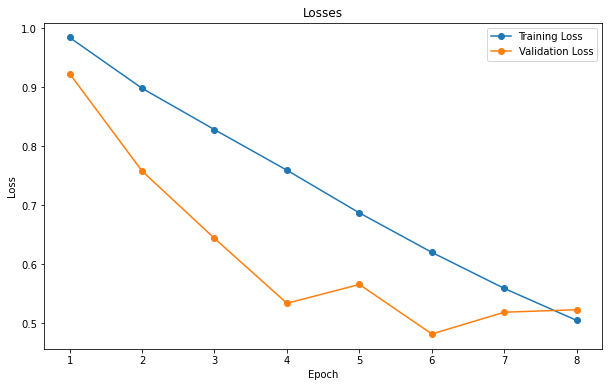

In [ ]:
plt.plot(range(1, len(train_loss) + 1), train_loss, label = 'Training Loss', marker='o')
plt.plot(range(1, len(dev_loss) + 1), dev_loss, label = 'Validation Loss', marker='o')
plt.title('Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracies Plot

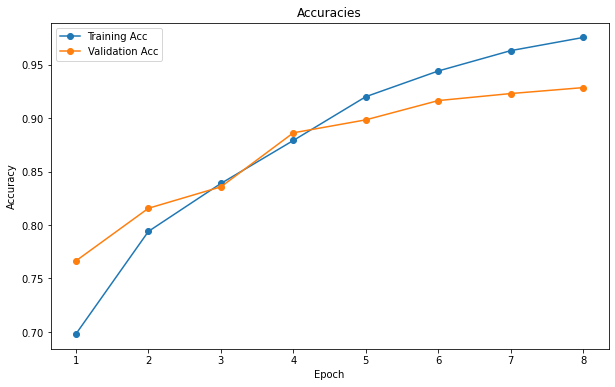

In [ ]:
plt.plot(range(1, len(train_acc) + 1), train_acc, label = 'Training Acc', marker='o')
plt.plot(range(1, len(dev_acc) + 1), dev_acc, label = 'Validation Acc', marker='o')
plt.title('Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### AUCs Plot

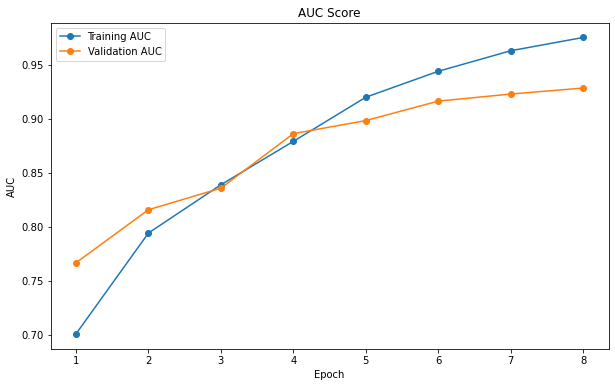

In [ ]:
plt.plot(range(1, len(train_auc) + 1), train_auc, label = 'Training AUC', marker='o')
plt.plot(range(1, len(dev_auc) + 1), dev_auc, label = 'Validation AUC', marker='o')
plt.title('AUC Score')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

#### Notes

We can see from training over 8 epochs that the optimal epoch number is around 6 epochs, where the validation loss is the smallest.

## Performance on Evaluation and Test Data

Unlike the training and validation data the test data has been sampled from the original distribution. This means it has roughly a 9:1 ditribution between real and fraudulent reviews. The validation set was instead samples from the balanced dataset as the training set

#### Setting to Evaluation Mode

In [ ]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Evaluation Set Performance

In [ ]:
input_ids, predictions, true_labels, attentions, losses = evaluate(batch_dev, model, device)

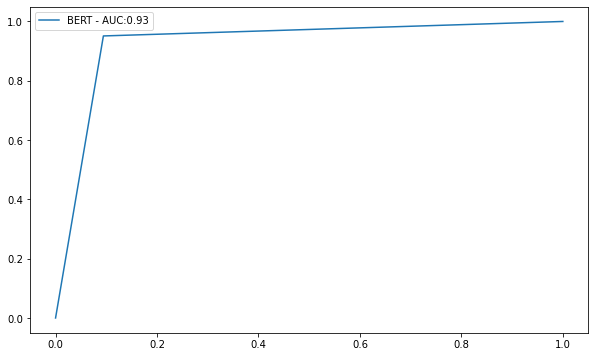

Evaluation Batch Accuracy = 0.9284391311668632

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2970
           1       0.91      0.95      0.93      2969

    accuracy                           0.93      5939
   macro avg       0.93      0.93      0.93      5939
weighted avg       0.93      0.93      0.93      5939



In [ ]:
from sklearn.metrics import classification_report

fpr, tpr, _ = roc_curve(true_labels, predictions, pos_label = 1)
plt.plot(fpr, tpr, label = 'BERT - AUC:' + str(auc(fpr, tpr).round(2)))

plt.legend()
plt.show()

acc_test = accuracy_score(true_labels, predictions) 
print('Evaluation Batch Accuracy = {}\n'.format(acc_test))
print(classification_report(true_labels, predictions))

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

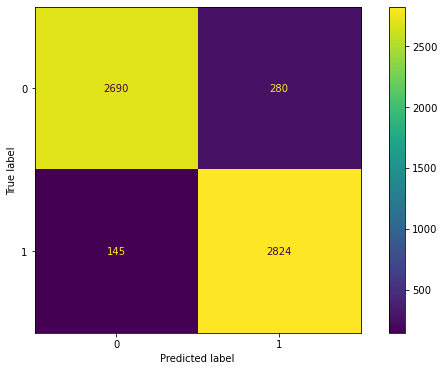

In [ ]:
cm = confusion_matrix(true_labels, predictions)
display = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
display.plot()                                                                  
plt.show()

#### Test Batches

In [ ]:
batch_test1 = get_batches(test1, tokenizer, batch_size=2)
batch_test2 = get_batches(test2, tokenizer, batch_size=2)
batch_test3 = get_batches(test3, tokenizer, batch_size=2)

test_batches = [batch_test1, batch_test2, batch_test3]

#### AUC Curves

Test Batch 1 Accuracy = 0.8608

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4505
           1       0.33      0.39      0.36       495

    accuracy                           0.86      5000
   macro avg       0.63      0.65      0.64      5000
weighted avg       0.87      0.86      0.87      5000

Test Batch 2 Accuracy = 0.8534

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      4502
           1       0.32      0.41      0.36       498

    accuracy                           0.85      5000
   macro avg       0.63      0.66      0.64      5000
weighted avg       0.87      0.85      0.86      5000

Test Batch 3 Accuracy = 0.8604

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4490
           1       0.35      0.41      0.38       510

    accuracy                           0.86      5000
   macro avg       0.64      0.6

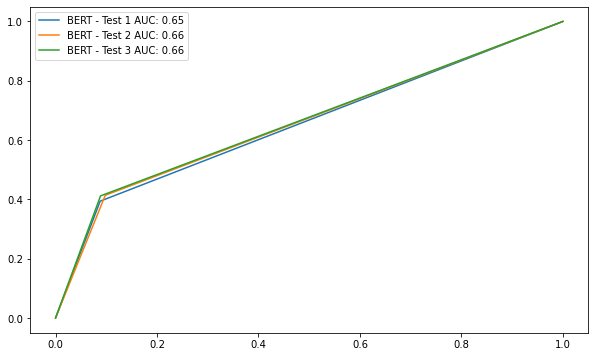

In [ ]:
test_batch_predictions, test_batch_labels = [], []

for i, test_batch in enumerate(test_batches):
    input_ids, predictions, true_labels, attentions, losses = evaluate(test_batch, model, device)

    fpr, tpr, _ = roc_curve(true_labels, predictions, pos_label = 1)
    plt.plot(fpr, tpr, label = 'BERT - Test {} AUC: {}'.format(i + 1, str(auc(fpr, tpr).round(2))))
    acc_test = accuracy_score(true_labels, predictions)
    print('Test Batch {} Accuracy = {}\n'.format(i + 1, acc_test))
    print(classification_report(true_labels, predictions))
    
    test_batch_predictions.append(predictions)
    test_batch_labels.append(true_labels)

plt.legend()
plt.show()

#### Confusion Matrix
Here are displayed the 3 confusion matrices for the 3 different test sets.

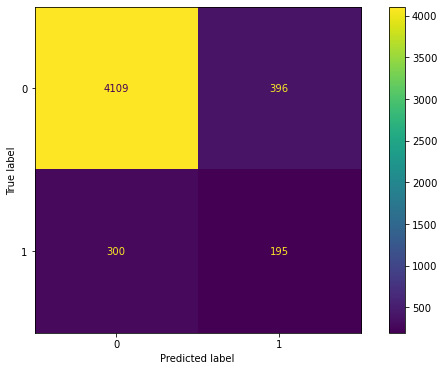

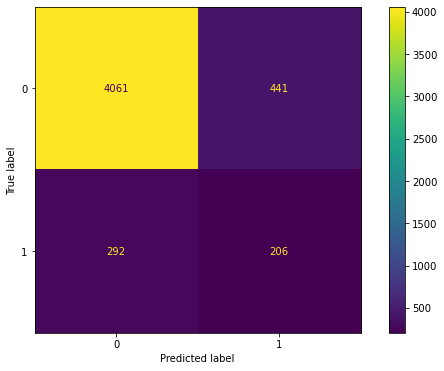

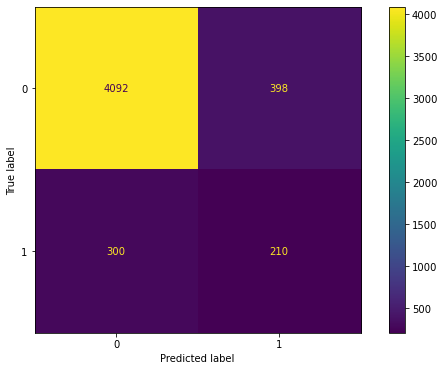

In [ ]:
for i in range(len(test_batch_predictions)):
    true_labels = test_batch_labels[i]
    predictions = test_batch_predictions[i]
    cm = confusion_matrix(true_labels, predictions)
    display = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
    display.plot()
plt.show()

#### Looking at the Model: All Fraudulent Reviews

In [ ]:
all_fake = df_train_fraud.sample(1000)

In [ ]:
fake_batch = get_batches(all_fake, tokenizer, batch_size=2)

In [ ]:
input_ids, predictions, true_labels, attentions, losses = evaluate(fake_batch, model, device)

In [ ]:
acc_test = accuracy_score(true_labels, predictions) 
print('Evaluation Batch Accuracy = {}\n'.format(acc_test))

Evaluation Batch Accuracy = 0.984



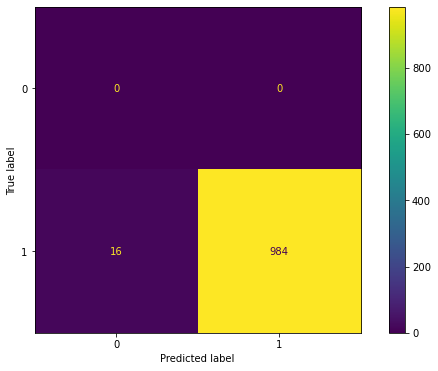

In [ ]:
cm = confusion_matrix(true_labels, predictions)
display = ConfusionMatrixDisplay(cm, display_labels = [0, 1])
display.plot()                                                                  
plt.show()

## Conclusion

We can see that the model performs very well, displaying the power of transformer models in the field of Natural Language Processing. The problem is really hard and the real world data is very skewed. Not many reviews are fraudulent and when the model see many sample of which only about 10 percent are of one class, it is gonna have a hard time predicting accurately for that specific class. This willl obviously affect its AUC score. But when seeing a balanced dataset or a dataset of element from only one label it is very confident in classifying them, easiliy reaching accuracies higher than 90 percent.

The problem is indeed challenging, even for us humans is very hard to distinguish between false and true reviews. However, we believe that if we can train on a larger, "balanced", and more appropriately processed dataset the result would be excellent, even on imbalanced testing sets. This brings us to our next steps. 

##### Next Steps:

Because many samples have very high word count and BERT can only take a maximum of 512 word, we could use another BERT model to summarize the reviews that are larger than, let's say, 450 word, to allow also space for the other features to be added to the text as we did initially. This woudl be a sort of dimensionality reduction on the data and would allow us to retain information from part of reviews which would be otherwise truncated. We were able to do this in another notebook but unfortunatley did not have the time to test it on the model.

Another thing that can be done is using a a BERT model for Text Generation to both study how the model thinks of fraudulent review and generate more fraudulent reviews to balance our dataset, giving us a more training samples adn allow us to train our model for even better performance. If these steps are done correctly, we believe the model to could reach more than 90% accuracy even on very inbalanced dataset and be an overall high-performing model. 

This example shows the power of BERT and its derivatives, and why they have achieved many of the testing benchmarks set by the community in the field of Natural Language Processing and how we can benefit from them in real worlds problems such as the one we tackled.

## Appendix A - Saving and Loading the Model

In [ ]:
import os

In [ ]:
def save(model, tokenizer):
    output_dir = './output'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print("Saving model to {}".format(output_dir))
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

save(model, tokenizer)

Saving model to ./output
